## Load dependencies

In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
import pandas as pd
import numpy as np
from pathlib import Path
import glob
import pickle
import json
import matplotlib.pyplot as plt
from lstm import LSTM_Simple
from metrics import exact_match_metric
from callbacks import NValidationSetsCallback, GradientLogger
from generator import DataGenerator, DataGeneratorSeq
from tqdm import tqdm
from evaluate_lstm import LSTM_Evaluator

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
print(tf.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

2.0.0-alpha0
GPU Available:  True


## Helper Function

In [59]:
def plot_two_results(result_1, result_2=None, experiments=['L&L'], title=''):
    labels = []
    array_1 = []
    array_2 = []
    
    for module in result_1:
        labels.append(module.split('__')[1])
        array_1.append(result_1[module])

    if result_2 is not None:
        for module in result_1:
            array_2.append(result_2[module])

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    if result_2 is not None:
        rects1 = ax.bar(x - width/2, array_1, width, label=experiments[0])
        rects2 = ax.bar(x + width/2, array_2, width, label=experiments[1])
    else:
        rects1 = ax.bar(x, array_1, width, label=experiments[0])


    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title('Evaluation scores: ' + title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=30, ha="right")
    ax.legend()


    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{0:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')


    if result_2 is not None:
        autolabel(rects2)

    autolabel(rects1)

    fig.tight_layout()
    plt.ylim([0, 1.1])
    plt.legend(loc='lower right')
    plt.show()

In [60]:
def concatenate_texts_individual(path, pattern):
    file_paths = list(path.glob('{}*.txt'.format(pattern)))
    
    input_texts = {}
    target_texts = {}

    for file_path in file_paths:
        if file_path.stem not in input_texts:
            input_texts[file_path.stem] = []
            target_texts[file_path.stem] = []
        
        with open(str(file_path), 'r', encoding='utf-8') as f:
            lines = f.read().split('\n')[:-1]

        input_texts[file_path.stem].extend(lines[0::2])
        target_texts[file_path.stem].extend(['\t' + target_text + '\n' for target_text in lines[1::2]])
        
    return input_texts, target_texts

In [61]:
def get_data(settings_path):
    with open(str(settings_path), 'r') as file:
        settings_dict = json.load(file)

    raw_path = Path(settings_dict['data_path'])
    interpolate_path = raw_path/'interpolate'
    extrapolate_path = raw_path/'extrapolate'
    train_easy_path = raw_path/'train-easy/'
    
    
    math_module = settings_dict["math_module"]
    train_level = settings_dict["train_level"]

    datasets = {
        'train':(raw_path, 'train-' + train_level + '/' + math_module),
        'interpolate':(interpolate_path, math_module),
        'extrapolate':(extrapolate_path, math_module)
               }

    input_texts = {}
    target_texts = {}

    for k, v in datasets.items():
        input_texts[k], target_texts[k] = concatenate_texts_individual(v[0], v[1])
    
    return settings_dict, input_texts, target_texts

In [62]:
def evaluate_arithmetics_interpolate(lstm_eval, input_texts, target_texts, print_res=False):
    test_set = 'interpolate'
    results = {}

    results_deepmind = {'arithmetic__add_or_sub': 0.875,
                        'arithmetic__add_or_sub_in_base': 0.9,
                        'arithmetic__add_sub_multiple': .95,
                        'arithmetic__mul_div_multiple': .95,
                        'arithmetic__nearest_integer_root': .875,
                        'arithmetic__mul': 0.45,
                        'arithmetic__div': 0.78,
                        'arithmetic__simplify_surd':0.16,
                        'arithmetic__mixed': 0.62}

    for module in input_texts[test_set]:
        metric = lstm_eval.evaluate_model(input_texts[test_set][module], target_texts[test_set][module])
        if print_res:
            print(test_set, module)
            print('metric:', metric, '\n')        
        results[module] = metric

    plot_two_results(results, results_deepmind, experiments=['L&L', 'DM'], title='interpolation')
    
    return results, results_deepmind

In [63]:
def evaluate_arithmetics_extrapolate(lstm_eval, input_texts, target_texts, print_res=False):
    test_set = 'extrapolate'
    results = {}

    results_deepmind = {'arithmetic__add_or_sub_big': 0.3,
                        'arithmetic__add_sub_multiple_longer': 0.55,
                        'arithmetic__mul_big': .225,
                        'arithmetic__mixed_longer': 0.1,
                        'arithmetic__mul_div_multiple_longer': 0.55,
                        'arithmetic__div_big':0.625}

    for module in input_texts[test_set]:
        
        metric = lstm_eval.evaluate_model(input_texts[test_set][module], target_texts[test_set][module])
        if print_res:
            print(test_set, module)
            print('metric:', metric, '\n')
        results[module] = metric

    plot_two_results(results, results_deepmind, experiments=['L&L', 'DM'], title='extrapolation')
    return results, results_deepmind

## Load datasets

In [65]:
job_ids = {1:'j4bu146wamlr9', 2: 'js0kldpwp1nhos', 3: 'jroi3ag4aros6'}

In [66]:
for key, value in job_ids.items():
    print(key, value)

1 j4bu146wamlr9
2 js0kldpwp1nhos
3 jroi3ag4aros6


In [67]:
model_path = Path('../../../storage/artifacts/'  + job_ids[1])
settings_dict, input_texts, target_texts = get_data(model_path/'settings.json')

## Evaluate datasets

EPOCH 1


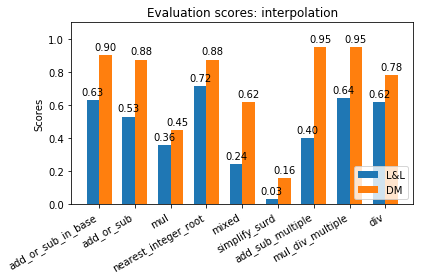

EPOCH 2


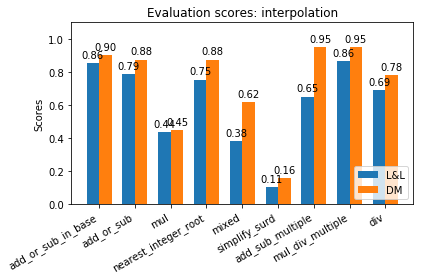

EPOCH 3


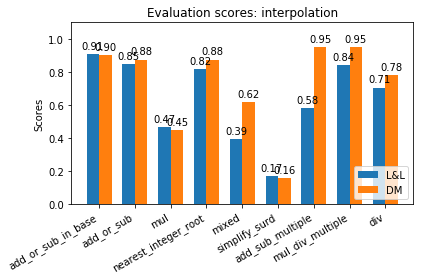

In [68]:
for epoch, job_id in job_ids.items():
    model_path = Path('../../../storage/artifacts/'  + job_id)
    lstm_eval = LSTM_Evaluator(model_path)
    print('EPOCH', epoch)
    res, res_dm = evaluate_arithmetics_interpolate(lstm_eval, input_texts, target_texts)

EPOCH 1


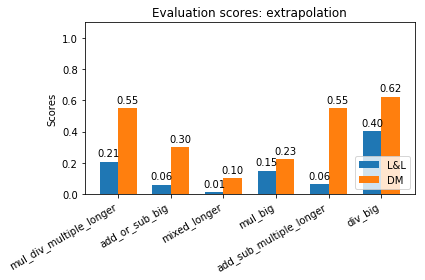

EPOCH 2


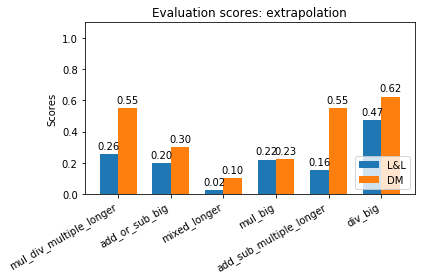

EPOCH 3


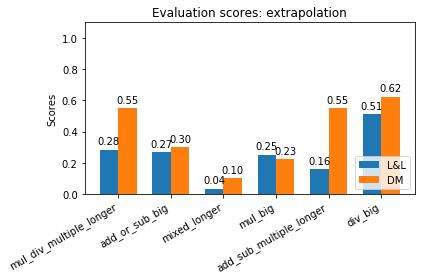

In [69]:
for epoch, job_id in job_ids.items():
    model_path = Path('../../../storage/artifacts/'  + job_id)
    lstm_eval = LSTM_Evaluator(model_path)
    print('EPOCH', epoch)
    res, res_dm = evaluate_arithmetics_extrapolate(lstm_eval, input_texts, target_texts)

## We can also test an indiviual string:

In [29]:
lstm_eval.predict_on_string('1 / 7')

'-4'

In [52]:
lstm_eval.predict_on_string('2*2')

''